In [86]:
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

## Data Inspection

In [87]:
file_path = 'online_retail_II.xlsx'

df_1 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
df_2 = pd.read_excel(file_path, sheet_name='Year 2010-2011')

df = pd.concat([df_1, df_2])

In [88]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [89]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


## Data Cleaning

In [90]:
df1 = df[(df['Price'] > 0) & (df['Quantity'] > 0)]
df1['Date'] = pd.to_datetime(df1['InvoiceDate']).dt.date
df1.drop(['InvoiceDate'], axis=1, inplace=True)

df1['Invoice'] = df1['Invoice'].astype(str)
df1 = df1[df1['Invoice'].str.startswith('C') == False]

df1 = df1.dropna(subset=['Description'])
df1['Description'] = df1['Description'].astype(str)

df1['StockCode'] = df1['StockCode'].astype(str)
df1['StockCode'] = df1['StockCode'].apply(str.upper)

df1 = df1[(df1['StockCode'].str.len() == 5) | (df1['StockCode'].str.len() == 6)]

C:\Users\xiang\AppData\Local\Temp\ipykernel_31792\982713068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['InvoiceDate']).dt.date
C:\Users\xiang\AppData\Local\Temp\ipykernel_31792\982713068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(['InvoiceDate'], axis=1, inplace=True)
C:\Users\xiang\AppData\Local\Temp\ipykernel_31792\982713068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [91]:
missing_values = df1.isna().sum()
print(missing_values)

print(df1.describe())

Invoice             0
StockCode           0
Description         0
Quantity            0
Price               0
Customer ID    234065
Country             0
Date                0
dtype: int64
           Quantity         Price    Customer ID
count  1.035658e+06  1.035658e+06  801593.000000
mean   1.099850e+01  3.343390e+00   15338.095812
std    1.268526e+02  6.952777e+00    1693.881217
min    1.000000e+00  3.000000e-02   12346.000000
25%    1.000000e+00  1.250000e+00   13988.000000
50%    3.000000e+00  2.100000e+00   15276.000000
75%    1.100000e+01  4.130000e+00   16809.000000
max    8.099500e+04  5.117030e+03   18287.000000


In [92]:
def remove_symbols(row):
    row = re.sub(r'[^a-zA-Z0-9\s]', ' ', row)
    row = ' '.join(row.split())
    return row

df1['Description'] = df1['Description'].apply(remove_symbols)

In [93]:
df1['Description'] = df1['Description'].str.lower()

In [94]:
df1.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date
0,489434,85048,15cm christmas glass ball 20 lights,12,6.95,13085.0,United Kingdom,2009-12-01
1,489434,79323P,pink cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01
2,489434,79323W,white cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01
3,489434,22041,record frame 7 single size,48,2.10,13085.0,United Kingdom,2009-12-01
4,489434,21232,strawberry ceramic trinket box,24,1.25,13085.0,United Kingdom,2009-12-01


In [95]:
df1 = df1.drop_duplicates()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002040 entries, 0 to 532617
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1002040 non-null  object 
 1   StockCode    1002040 non-null  object 
 2   Description  1002040 non-null  object 
 3   Quantity     1002040 non-null  int64  
 4   Price        1002040 non-null  float64
 5   Customer ID  775575 non-null   float64
 6   Country      1002040 non-null  object 
 7   Date         1002040 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 68.8+ MB


## Feature Extraction for Customisable Products

In [96]:
products = df1[['StockCode', 'Description']].drop_duplicates()
products = products.reset_index(drop=True)
print(len(products))
products.head()

5288


,StockCode,Description
0,85048,15cm christmas glass ball 20 lights
1,79323P,pink cherry lights
2,79323W,white cherry lights
3,22041,record frame 7 single size
4,21232,strawberry ceramic trinket box


In [97]:
vectorizer = TfidfVectorizer(min_df=1)
tfidf_matrix = vectorizer.fit_transform(products['Description'])

cosine_sim = cosine_similarity(tfidf_matrix)
threshold = 0.75

products['Customisable'] = False
products['Variations'] = ''

In [98]:
for i, description in enumerate(products['Description']):
    similar_indices = [j for j in range(len(products)) if (cosine_sim[i, j] > threshold and i!=j)]
    variations = []
    for j in similar_indices:
        temp = products['Description'].iloc[j]
        if (temp not in variations) and description != temp:
            variations.append(temp)
    if variations:
        products.at[i, 'Customisable'] = True
        products.at[i, 'Variations'] = variations

In [99]:
customisable = products[products['Customisable']].reset_index(drop=True)
print(len(customisable))
customisable.head()

2468


,StockCode,Description,Customisable,Variations
0,79323P,pink cherry lights,True,"[white cherry lights, silver cherry lights, bl..."
1,79323W,white cherry lights,True,"[pink cherry lights, silver cherry lights, bla..."
2,21232,strawberry ceramic trinket box,True,"[ceramic strawberry trinket tray, strawberry c..."
3,21871,save the planet mug,True,[paperweight save the planet]
4,21523,fancy font home sweet home doormat,True,"[spotty home sweet home doormat, door mat fanc..."


In [100]:
customisable['Base Product'] = ''

for i, description in enumerate(customisable['Description']):
    variations = customisable.at[i, 'Variations']
    description_words = description.split()
    common = set(description_words)
    for variation in variations:
        variation_words = variation.split()
        common = common.intersection(set(variation_words))
    customisable.at[i, 'Base Product'] = ' '.join([word for word in description_words if word in common])

In [101]:
customisable.head()

,StockCode,Description,Customisable,Variations,Base Product
0,79323P,pink cherry lights,True,"[white cherry lights, silver cherry lights, bl...",cherry lights
1,79323W,white cherry lights,True,"[pink cherry lights, silver cherry lights, bla...",cherry lights
2,21232,strawberry ceramic trinket box,True,"[ceramic strawberry trinket tray, strawberry c...",strawberry ceramic trinket
3,21871,save the planet mug,True,[paperweight save the planet],save the planet
4,21523,fancy font home sweet home doormat,True,"[spotty home sweet home doormat, door mat fanc...",home sweet home


## Variation Extraction

In [102]:
nlp = spacy.load("en_core_web_sm")

In [103]:
colors = [
    "red", "blue", "green", "yellow", "black", "white", "pink", "purple", "orange", "brown", "gray", "grey", 
    "beige", "tan", "maroon", "cyan", "magenta", "crimson", "scarlet", "burgundy", "ruby", "rose", "wine", 
    "cherry", "coral", "navy", "sky", "teal", "cobalt", "turquoise", "azure", "sapphire", "baby blue", 
    "lime", "olive", "emerald", "mint", "sea green", "forest", "jade", "chartreuse", "golden", "lemon", 
    "mustard", "amber", "sunflower", "canary", "jet", "charcoal", "ebony", "onyx", "matte black", "ink", 
    "ivory", "snow", "cream", "pearl", "alabaster", "off-white", "bone", "blush", "fuchsia", "hot pink", 
    "peach", "salmon", "bubblegum", "lavender", "lilac", "violet", "plum", "amethyst", "mauve", "orchid", 
    "tangerine", "apricot", "rust", "chocolate", "coffee", "mahogany", "chestnut", "walnut", "bronze", 
    "cocoa", "slate", "ash", "dove", "silver", "steel", "graphite", "sand", "khaki", "taupe", "buff", 
    "camel", "almond", "gold", "silver", "copper", "brass", "rose gold", "platinum", "metallic", 
    "pastel pink", "pastel blue", "pastel green", "pastel yellow", "pastel purple", "pastel orange", 
    "neon pink", "neon green", "neon yellow", "neon blue", "neon orange", "terracotta", "sage", "moss", 
    "umber", "ochre", "clay"
]

materials = [
    "metal", "wood", "plastic", "ceramic", "glass", "leather", "fabric", "stone", "marble", "wool", 
    "cotton", "silk", "linen", "polyester", "nylon", "acrylic", "brass", "steel", "iron", "aluminum", 
    "copper", "bronze", "bamboo", "rubber", "porcelain", "velvet", "suede", "lace", "canvas", "foam", 
    "cardboard", "paper", "resin", "fiber", "synthetic", "polyurethane", "faux leather", "stainless steel",
    "plexiglass", "carbon fiber", "jute", "rattan", "hemp", "wicker", "spandex", "microfiber", "cashmere",
    "denim", "tweed", "charcoal", "glass fiber", "kevlar", "epoxy", "latex", "mesh", "plastic", "zinc"
]

sizes = [
    "extra small", "small", "medium", "large", "extra large", "extra extra large", "xx-small", 
    "x-small", "small", "medium", "large", "x-large", "xx-large", "xxx-large",
    "xs", "s", "m", "l", "xl", "xxl", "xxxl", "xxxxl", "one size", "plus size", "petite", 
    "tall", "regular", "slim fit", "relaxed fit", "oversized", "junior", "youth",
]

styles = [
    "vintage", "bohemian", "modern", "minimalist", "rustic", "gothic", "retro", 
    "industrial", "mid-century modern", "art deco", "shabby chic", "farmhouse", 
    "coastal", "nautical", "scandinavian", "victorian", "steampunk", "futuristic",
    "baroque", "asian-inspired", "mediterranean", "southwestern", "tropical", 
    "contemporary", "urban", "eclectic", "colonial", "beach", "tribal", 
    "organic", "romantic", "classical", "luxury", "glam", "zen", "avant-garde", 
    "cyberpunk", "art nouveau", "country"
]

In [104]:
def extract_variation(description, base_product):
    variation_type = set()
    variation_detail = ""
    
    description_set = set(description.lower().split())
    base_product_set = set(base_product.lower().split())
    
    difference_set = description_set - base_product_set
    
    if not difference_set:
        return None, None, 0

    difference_text = ' '.join(difference_set)
    doc = nlp(difference_text)  
    
    for token in doc:
        if token.text in colors:
            variation_type.add("colour")
            variation_detail += f"colour: {token.text}, "
        elif token.text in sizes:
            variation_type.add("size")
            variation_detail += f"size: {token.text}, "
        elif token.text in materials:
            variation_type.add("material")
            variation_detail += f"material: {token.text}, "
        elif token.text in styles:
            variation_type.add("style")
            variation_detail += f"style: {token.text}, "

    bundle_match = re.search(r'\b(set of|pack of)\s?\d+', description, re.IGNORECASE)
    if bundle_match:
        variation_type.add("bundle")
        variation_detail += f"bundle: {bundle_match.group()}, "

    remaining_difference = difference_set - set(colors) - set(sizes) - set(materials) - set(styles)
    if bundle_match:
        remaining_difference -= set(bundle_match.group().split())
    if remaining_difference:
        variation_type.add("miscellaneous")
        variation_detail += f"miscellaneous: {' '.join(remaining_difference)}, "
    
    customisation_complexity = len(variation_type)
    

    variation_type = ', '.join(variation_type) if variation_type else None
    variation_detail = variation_detail.strip(', ') if variation_detail else None

    return variation_type,  variation_detail, customisation_complexity

def extract_material(description): 
    doc = nlp(description)
    material = None

    for token in doc:
        if token.text.lower() in materials:
            material = token.text
            break
        
    if not material:
        material = "polymer"

    return material

In [105]:
customisable[['Variation Type', 'Variation Detail', 'Customisation Complexity']] = customisable.apply(lambda x: pd.Series(extract_variation(x['Description'], x['Base Product'])), axis=1)
customisable['Material'] = customisable['Description'].apply(extract_material)
customisable['Customisation Complexity'] = customisable['Customisation Complexity'].astype(int)
customisable = customisable[customisable['Customisation Complexity'] > 0]

In [125]:
customisable.head(5)

,StockCode,Description,Customisable,Variations,Base Product,Variation Type,Variation Detail,Customisation Complexity,Material
0,79323P,pink cherry lights,True,"[white cherry lights, silver cherry lights, bl...",cherry lights,colour,colour: pink,1,polymer
1,79323W,white cherry lights,True,"[pink cherry lights, silver cherry lights, bla...",cherry lights,colour,colour: white,1,polymer
2,21232,strawberry ceramic trinket box,True,"[ceramic strawberry trinket tray, strawberry c...",strawberry ceramic trinket,miscellaneous,miscellaneous: box,1,ceramic
3,21871,save the planet mug,True,[paperweight save the planet],save the planet,miscellaneous,miscellaneous: mug,1,polymer
4,21523,fancy font home sweet home doormat,True,"[spotty home sweet home doormat, door mat fanc...",home sweet home,miscellaneous,miscellaneous: font fancy doormat,1,polymer


In [107]:
df1.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date
0,489434,85048,15cm christmas glass ball 20 lights,12,6.95,13085.0,United Kingdom,2009-12-01
1,489434,79323P,pink cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01
2,489434,79323W,white cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01
3,489434,22041,record frame 7 single size,48,2.10,13085.0,United Kingdom,2009-12-01
4,489434,21232,strawberry ceramic trinket box,24,1.25,13085.0,United Kingdom,2009-12-01


In [108]:
retail = pd.merge(df1, customisable, on=['StockCode', 'Description'], how='left')
retail = retail[retail['Customisable'] == True]
retail = retail.drop(columns=['Customisable'])
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393517 entries, 1 to 1002038
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Invoice                   393517 non-null  object 
 1   StockCode                 393517 non-null  object 
 2   Description               393517 non-null  object 
 3   Quantity                  393517 non-null  int64  
 4   Price                     393517 non-null  float64
 5   Customer ID               302078 non-null  float64
 6   Country                   393517 non-null  object 
 7   Date                      393517 non-null  object 
 8   Variations                393517 non-null  object 
 9   Base Product              393517 non-null  object 
 10  Variation Type            393517 non-null  object 
 11  Variation Detail          393517 non-null  object 
 12  Customisation Complexity  393517 non-null  float64
 13  Material                  393517 non-null  objec

In [109]:
retail.head(5)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date,Variations,Base Product,Variation Type,Variation Detail,Customisation Complexity,Material
1,489434,79323P,pink cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01,"[white cherry lights, silver cherry lights, bl...",cherry lights,colour,colour: pink,1.0,polymer
2,489434,79323W,white cherry lights,12,6.75,13085.0,United Kingdom,2009-12-01,"[pink cherry lights, silver cherry lights, bla...",cherry lights,colour,colour: white,1.0,polymer
4,489434,21232,strawberry ceramic trinket box,24,1.25,13085.0,United Kingdom,2009-12-01,"[ceramic strawberry trinket tray, strawberry c...",strawberry ceramic trinket,miscellaneous,miscellaneous: box,1.0,ceramic
6,489434,21871,save the planet mug,24,1.25,13085.0,United Kingdom,2009-12-01,[paperweight save the planet],save the planet,miscellaneous,miscellaneous: mug,1.0,polymer
7,489434,21523,fancy font home sweet home doormat,10,5.95,13085.0,United Kingdom,2009-12-01,"[spotty home sweet home doormat, door mat fanc...",home sweet home,miscellaneous,miscellaneous: font fancy doormat,1.0,polymer


## EDA

In [110]:
print(retail['Price'].describe())

count    393517.000000
mean          3.343687
std           9.927423
min           0.060000
25%           1.250000
50%           2.100000
75%           4.130000
max        5117.030000
Name: Price, dtype: float64


In [111]:
p20 = retail['Price'].quantile(0.2)
p80 = retail['Price'].quantile(0.8)
retail2 = retail[(retail['Price'] >= p20) & (retail['Price'] <= p80)].reset_index(drop=True)

### Plots


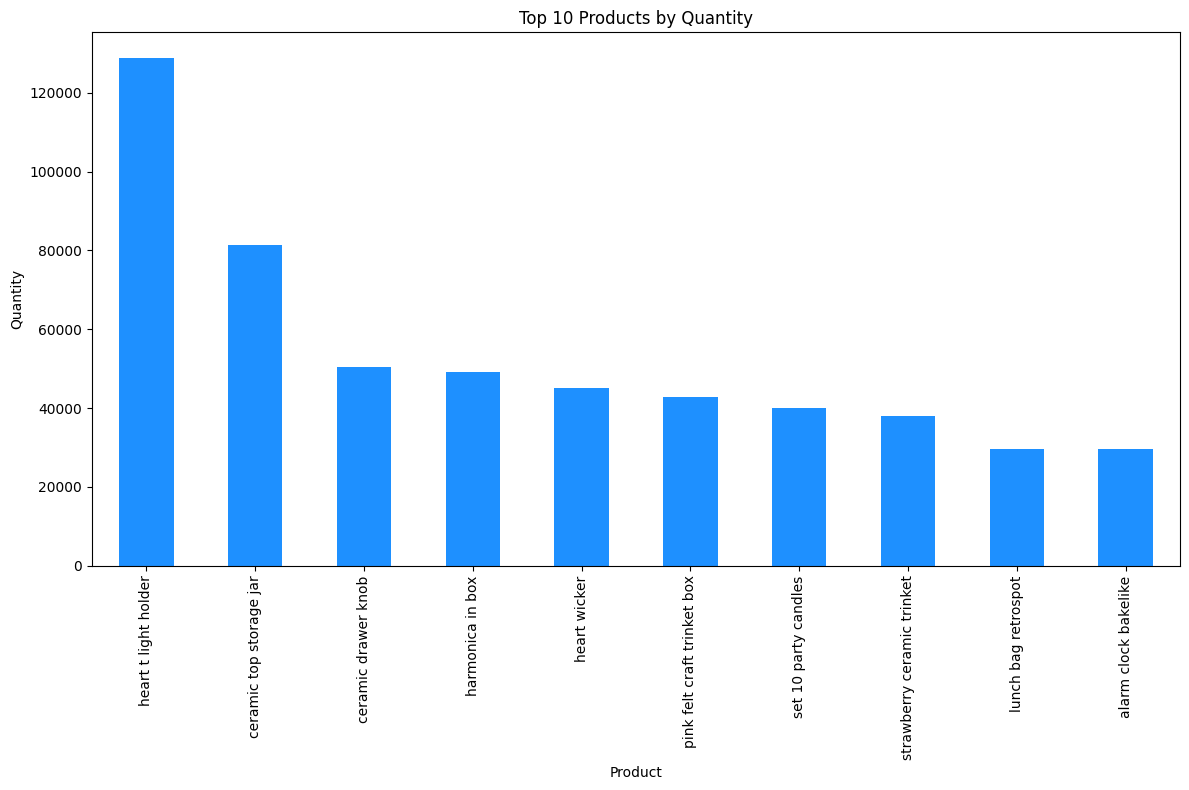

In [112]:
top_products = retail2.groupby('Base Product')['Quantity'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
plot1 = top_products.head(10).plot(kind='bar', color = 'dodgerblue', title='Top 10 Products by Quantity')
plot1.set_ylabel('Quantity')
plot1.set_xlabel('Product')
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

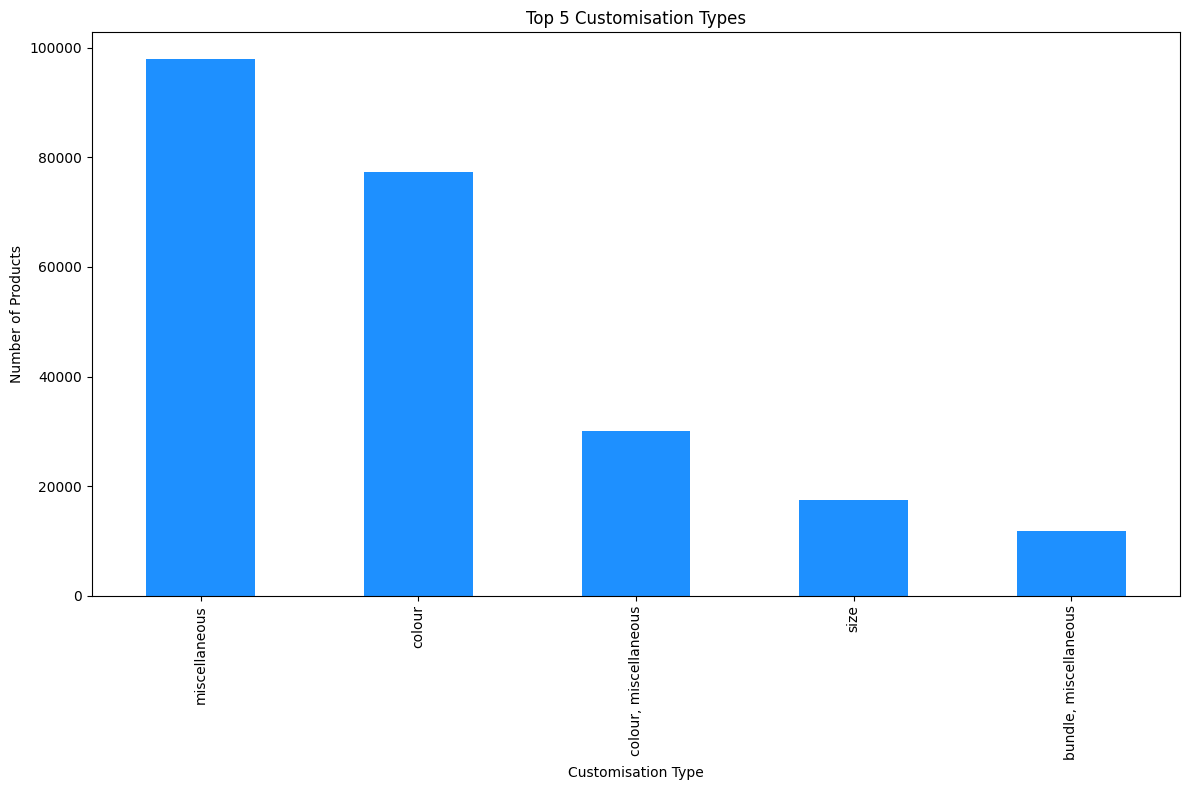

In [113]:
top_customisations = retail2['Variation Type'].value_counts().head(5)
plt.figure(figsize=(12, 8))
plot2 = top_customisations.plot(kind='bar', color='dodgerblue', title='Top 5 Customisation Types')
plot2.set_ylabel('Number of Products')
plot2.set_xlabel('Customisation Type')
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.show()

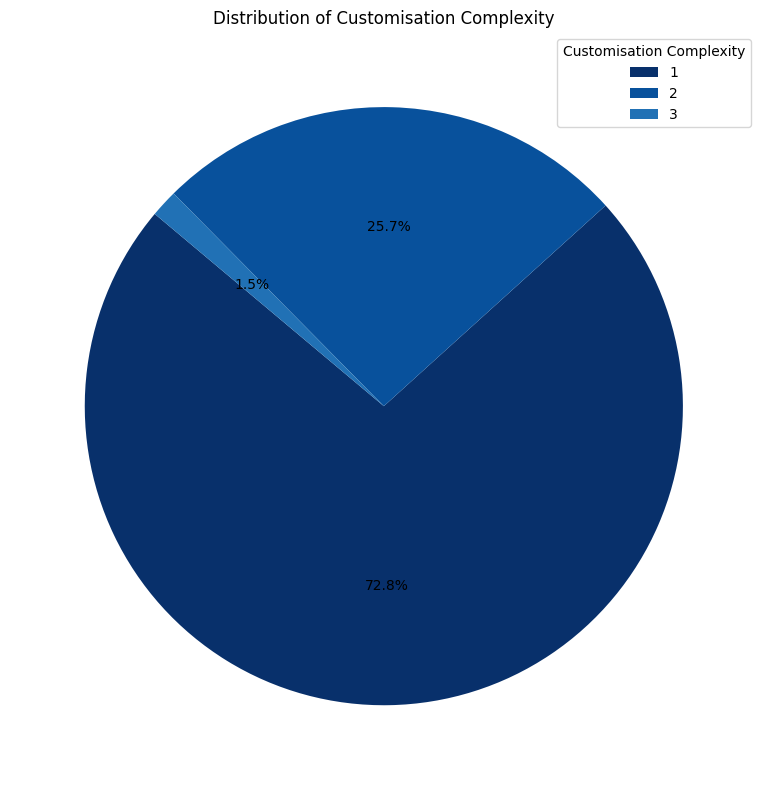

In [114]:
retail2['Customisation Complexity'] = retail2['Customisation Complexity'].astype(int)
complexity_counts = retail2['Customisation Complexity'].value_counts().sort_index()
plt.figure(figsize=(12, 8))
colors = ['#08306b', '#08519c', '#2171b5', '#4292c6']
plot3 = complexity_counts.plot(
    kind='pie', 
    colors=colors,
    labels=None,  
    autopct='%1.1f%%',  
    startangle=140,
    title='Distribution of Customisation Complexity',
    legend=True
)
plt.legend(title='Customisation Complexity', loc='upper right', labels=complexity_counts.index)
plot3.set_ylabel('')
plt.tight_layout()
plt.show()


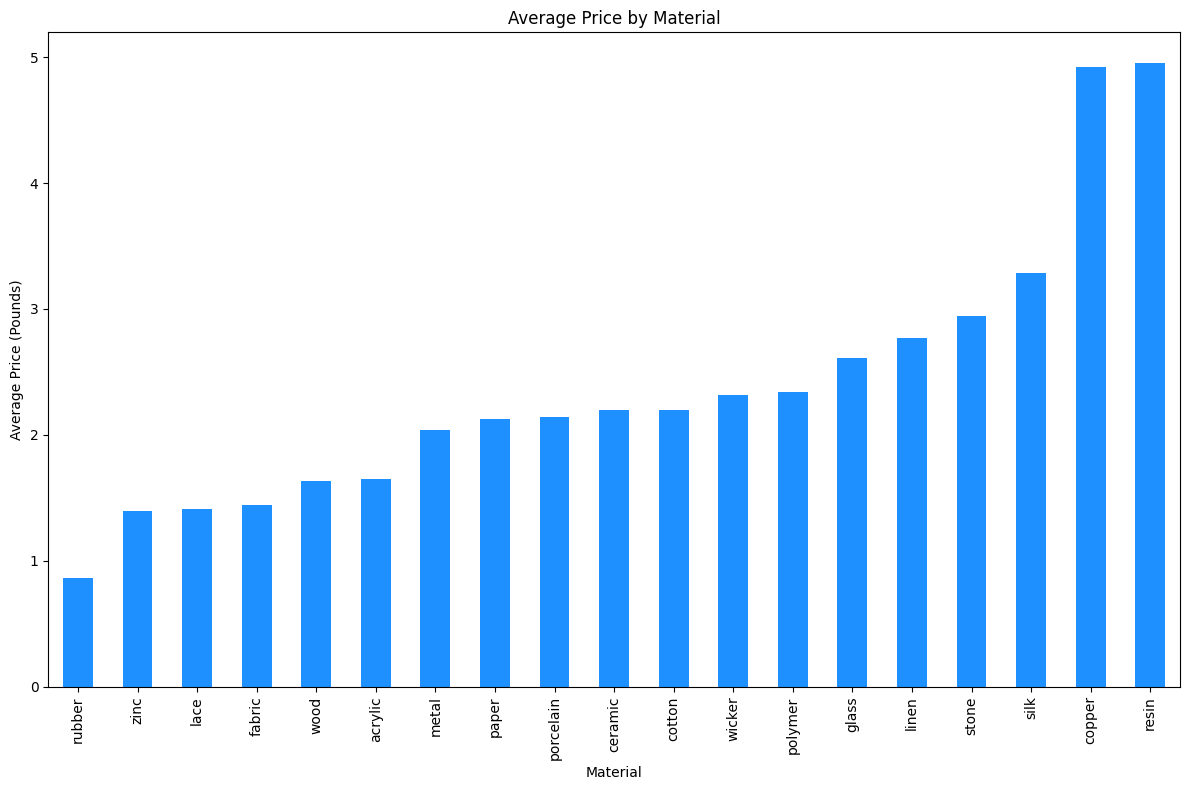

In [115]:
material_price_corr = retail2.groupby('Material')['Price'].mean().sort_values()
plt.figure(figsize=(12, 8))
plot4 = material_price_corr.plot(kind='bar',color='dodgerblue', title='Average Price by Material')
plot4.set_ylabel('Average Price (Pounds)')
plot4.set_xlabel('Material')
plot4.set_xticklabels(plot4.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix')

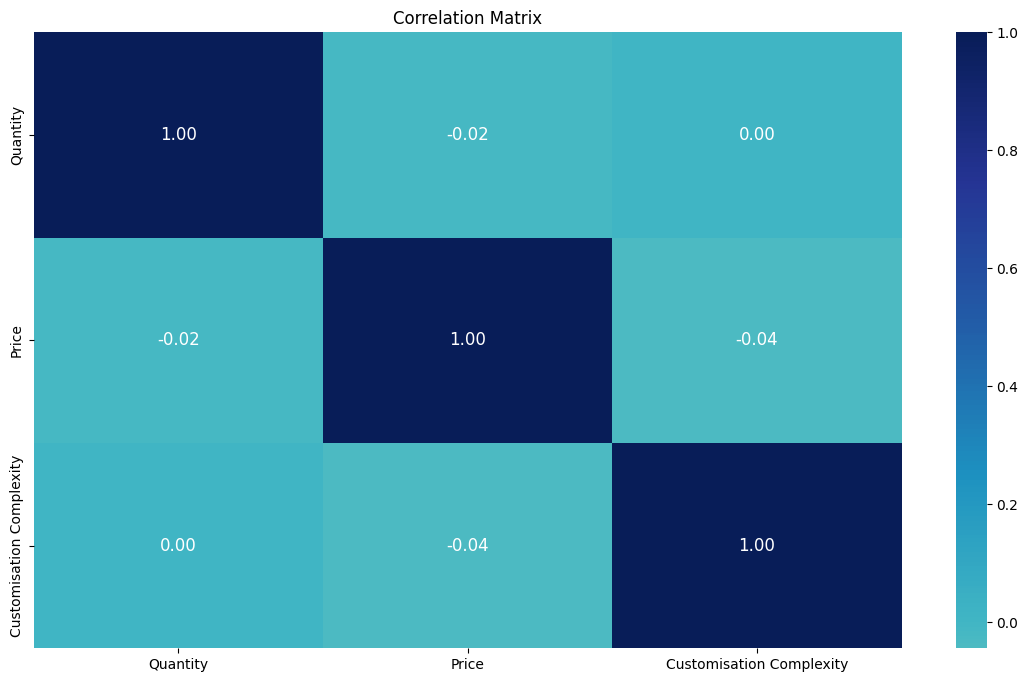

In [116]:
correlation_matrix = retail2[['Quantity', 'Price', 'Customisation Complexity']].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap ='YlGnBu', center=0, fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation Matrix')


C:\Users\xiang\AppData\Local\Temp\ipykernel_31792\387010679.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=retail2, x='Customisation Complexity', y='Price', palette='Blues')


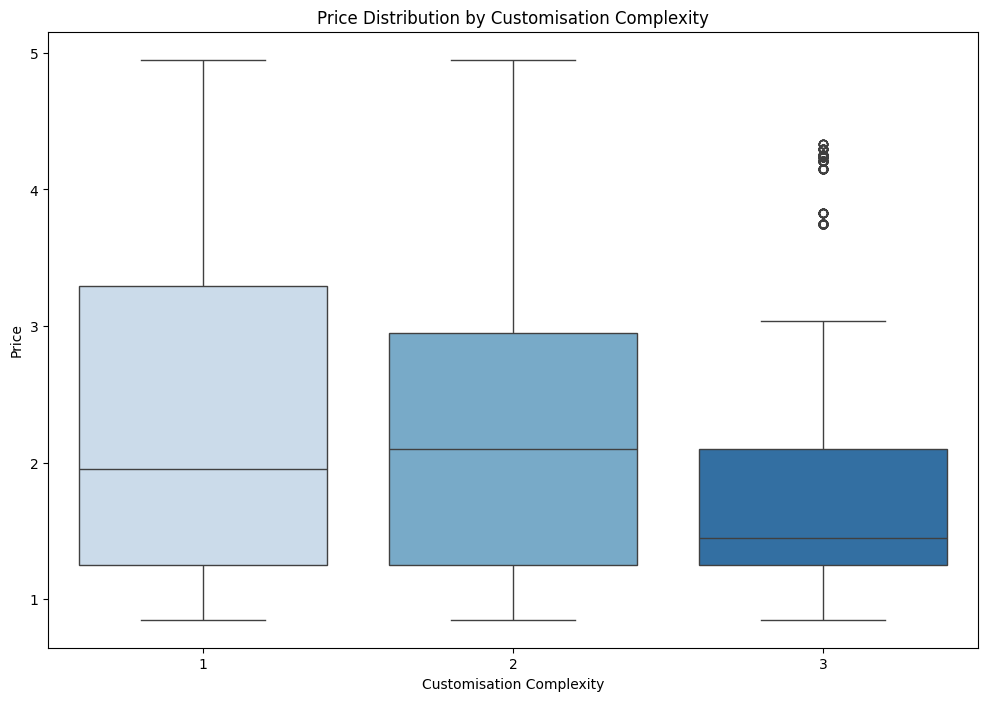

In [117]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=retail2, x='Customisation Complexity', y='Price', palette='Blues')

plt.title('Price Distribution by Customisation Complexity')
plt.xlabel('Customisation Complexity')
plt.ylabel('Price')

plt.show()

### Count Data Occurences for Sequential Data

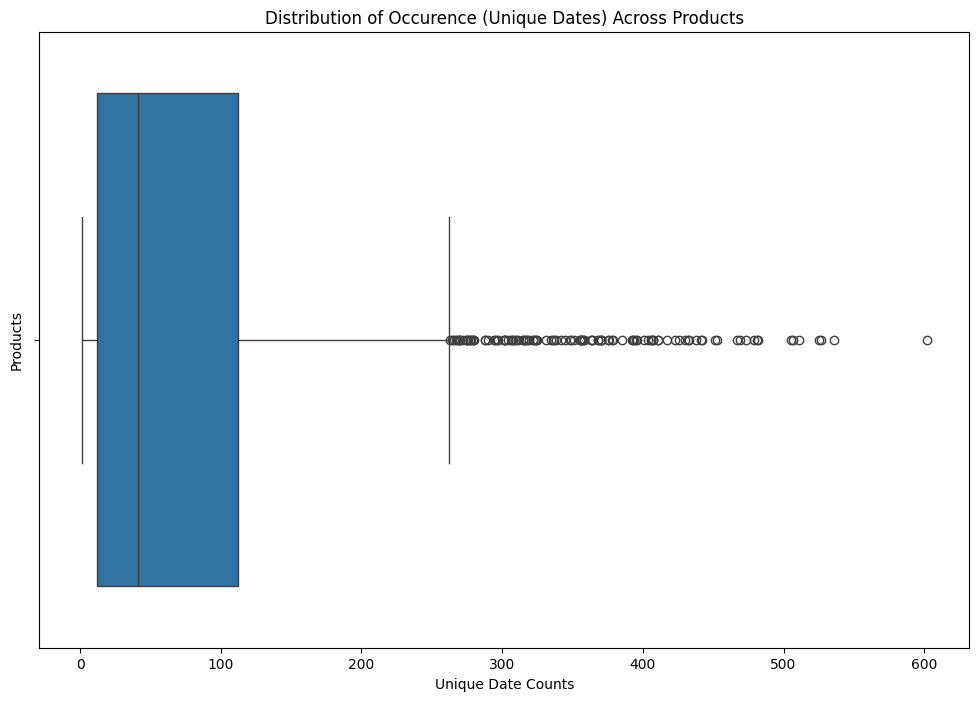

                              Description  Occurences
1821   white hanging heart t light holder         602
1715       strawberry ceramic trinket box         536
757      hanging heart jar t light holder         527
758     hanging heart zinc t light holder         525
1184    pink cream felt craft trinket box         511
...                                   ...         ...
567   fine silver necklace w pastel flowe           1
0          11 pc ceramic tea set polkadot           1
1853           wooden box advent calendar           1
1856    wooden heart christmas scandispot           1
1878      yellow giant garden thermometer           1

[1902 rows x 2 columns]


,Occurences
count,1902.000000
mean,79.232387
std,95.843116
min,1.000000
25%,12.000000
50%,41.000000
75%,112.000000
max,602.000000


In [118]:
occurences = retail2.groupby('Description')['Date'].nunique().reset_index(name='Occurences')

plt.figure(figsize=(12, 8))

sns.boxplot(data=occurences, x='Occurences', orient='h')

plt.title("Distribution of Occurence (Unique Dates) Across Products")
plt.xlabel("Unique Date Counts")
plt.ylabel("Products")
plt.show()

print(occurences.sort_values(by='Occurences', ascending=False))
occurences.describe()

In [119]:
min_unique_dates = 60

sufficient_data_products = occurences[occurences['Occurences'] >= min_unique_dates]

retail2 = retail2[retail2['Description'].isin(sufficient_data_products['Description'])]

In [120]:
retail3 = retail2.copy()
retail3 = retail3.drop(['StockCode', 'Customer ID', 'Invoice', 'Variations'], axis=1)
retail3.reset_index(drop=True, inplace=True)
order = [
    'Base Product', 'Description', 'Quantity', 'Country', 'Variation Type', 'Variation Detail', 'Customisation Complexity', 'Material',
    'Price', 'Date']
retail3 = retail3[order]

## Export Data

In [121]:
final = retail3.groupby(['Base Product', 'Description', 'Date']).agg({
    'Quantity': 'sum', 
    'Variation Type': 'first',
    'Variation Detail': 'first',
    'Customisation Complexity': 'first',
    'Material': 'first',
    'Price': 'first',  
    'Country': 'first'
}).reset_index()

In [ ]:
final.to_excel('products.xlsx', index=False)

In [123]:
final.head()

,Base Product,Description,Date,Quantity,Variation Type,Variation Detail,Customisation Complexity,Material,Price,Country
0,12 pencils tall tube,12 pencils tall tube skulls,2009-12-01,28,miscellaneous,miscellaneous: skulls,1,polymer,0.85,United Kingdom
1,12 pencils tall tube,12 pencils tall tube skulls,2009-12-02,25,miscellaneous,miscellaneous: skulls,1,polymer,0.85,United Kingdom
2,12 pencils tall tube,12 pencils tall tube skulls,2009-12-03,28,miscellaneous,miscellaneous: skulls,1,polymer,0.85,United Kingdom
3,12 pencils tall tube,12 pencils tall tube skulls,2009-12-04,79,miscellaneous,miscellaneous: skulls,1,polymer,0.85,United Kingdom
4,12 pencils tall tube,12 pencils tall tube skulls,2009-12-05,12,miscellaneous,miscellaneous: skulls,1,polymer,0.85,United Kingdom
